# Install COCO

In [1]:
# prompt: how to mount to my drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_0b7lf1q
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_0b7lf1q
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp311-cp311-linux_x86_64.whl size=399219 sha256=d3694f83c7d2a28aa4f074270371ed93338fb678f9a4b93ed1be1eaa77e5cefe
  Stored in directory: /tmp/pip-ephem-wheel-cache-fy4bem93/wheels/6d/69/75/358c50a37672dfda8d74ba3b30ec49fb75d52f7c081886d503
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8


# Import Libraries

In [3]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Dataset Exploration

In [4]:
dataDir='/content/drive/MyDrive/data'
dataTrain ='train'
dataVal='val'
dataTest='test'
annFileVal='{}/{}/COCO_{}_annos.json'.format(dataDir,dataVal,dataVal)
annFileTrain='{}/{}/COCO_{}_annos.json'.format(dataDir,dataTrain,dataTrain)


In [5]:
# Initialize the COCO api for instance annotations
coco=COCO(annFileVal)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=1.46s)
creating index...
index created!
[{'id': 1, 'name': 'damage', 'supercategory': 'part'}]


Number of images containing all the  classes: 11
{'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '42.jpg', 'flickr_url': '', 'height': 1024, 'id': 5, 'license': 1, 'width': 1024}


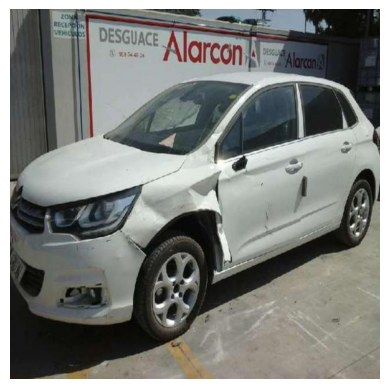

In [6]:
imgIds = coco.getImgIds(catIds=catIDs)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)
I = io.imread('{}/{}/{}'.format(dataDir,dataVal,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

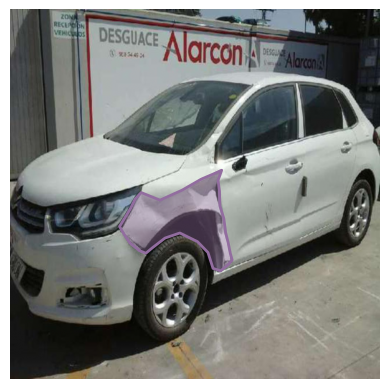

In [7]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIDs, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

# Install Detectron2

In [8]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-by6h4u_d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-by6h4u_d
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.7/458.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 

In [9]:
import torch, torchvision, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [10]:
print(torch.__version__, torch.cuda.is_available())

2.5.1+cu121 False


In [11]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader
import detectron2.data.transforms as T
from detectron2.utils.visualizer import ColorMode

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer

# Register COCO dataset

In [12]:
from detectron2.data.datasets import register_coco_instances
try:
    register_coco_instances("dataset_train", {}, annFileTrain, "{}/{}".format(dataDir,dataTrain))
    register_coco_instances("dataset_val", {}, annFileVal, "{}/{}".format(dataDir, dataVal))
except:
    print('Dataset is already registered!')
    pass

In [13]:
dataset_dicts = DatasetCatalog.get("dataset_train")
metadata_dicts = MetadataCatalog.get("dataset_train")

[01/28 17:33:35 d2.data.datasets.coco]: Loading /content/drive/MyDrive/data/train/COCO_train_annos.json takes 1.87 seconds.
[01/28 17:33:35 d2.data.datasets.coco]: Loaded 59 images in COCO format from /content/drive/MyDrive/data/train/COCO_train_annos.json


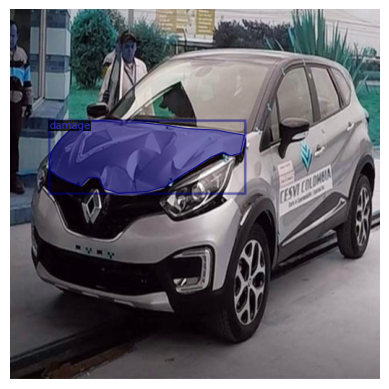

In [14]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_dicts, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.axis('off')
    plt.imshow(out.get_image()[:, :, ::-1])

# Training

## Create evaluator and augmentation

In [15]:
# create trainer with evaluation and augmentation
# https://github.com/facebookresearch/detectron2/blob/main/tools/train_net.py
class Trainer(DefaultTrainer): # inherit from default trainer
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "evaluator")
        return COCOEvaluator(dataset_name, ("bbox", "segm"), output_folder)
    @classmethod
    def build_train_loader(cls, cfg):
        augs = [
            T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
            T.RandomRotation([-90, 90]),
            T.RandomLighting(0.5)
        ]
        mapper = DatasetMapper(cfg, is_train=True, augmentations=augs)
        return build_detection_train_loader(cfg, mapper=mapper)


In [17]:
# list of configs: https://github.com/facebookresearch/detectron2/blob/main/detectron2/config/defaults.py

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2 # 2 is enough
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001 #0.0005 #0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []      # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (damage). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.TEST.EVAL_PERIOD = 200 # eval every 200 iter

# Clear any logs from previous runs
import shutil
try:
  shutil.rmtree(cfg.OUTPUT_DIR)
except:
  print('no folder found, pass')

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

# Training Graph

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

# Evaluation

In [ ]:
if os.path.exists(cfg.MODEL.WEIGHTS):
       print("File exists")
else:
       print("File not found")

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

# Inference Val

In [ ]:
def inference(listImg):
    for img in listImg:
        im = io.imread(img)
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=val_metadata_dicts,
                       scale=0.5,
    #                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=(50,50))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(out.get_image()[:, :, ::-1])
        masks = outputs['instances'].pred_masks.cpu().numpy().astype('uint8')
        total_area = outputs['instances'].pred_boxes.area().sum()
        plt.text(20, 40, 'Number of Damaged: {}\n Damaged Area: {} px^2'.format(len(masks), total_area), fontsize = 40, color = 'white', bbox = dict(facecolor = 'red', alpha = 0.5))
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(im)
        plt.show()

In [ ]:
val_dataset_dicts = DatasetCatalog.get("dataset_val")
val_metadata_dicts = MetadataCatalog.get("dataset_val")

In [ ]:
imgVal = [d['file_name'] for d in random.sample(val_dataset_dicts, 6)]

In [ ]:
inference(imgVal)

# Inference Test

In [ ]:
import glob

testImg = glob.glob('/{}/{}/*.jpg'.format(dataDir,dataTest))
print(len(testImg),'items, sample:', testImg[0])

inference(testImg)

In [ ]:
# prompt: zip the output folder using shmutil

import shutil
import os

# Specify the output directory you want to zip
output_dir = "output"  # Replace with your actual output directory

# Create the zip archive
shutil.make_archive("output", 'zip', output_dir)

# (Optional) You can then download the zip file in colab using the following
# from google.colab import files
# files.download('output.zip')

'/content/output.zip'

In [ ]:
# prompt: now i need to load the model from output folder

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

In [ ]:
# prompt: give me complete code to load and run the model locally

import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
import os
import glob

# Setup detectron2 logger
setup_logger()

# Create a configuration object
cfg = get_cfg()

# Load the pre-trained model configuration
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Specify the path to your trained model weights
cfg.MODEL.WEIGHTS = os.path.join("output", "model_final.pth") # Replace with the correct path to your model

# Set the threshold for object detection confidence
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

# Create a predictor instance
predictor = DefaultPredictor(cfg)

# Function for inference
def inference(listImg):
    for img in listImg:
        im = cv2.imread(img) # Use cv2.imread for local environment
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("dataset_val"), scale=0.5) # Replace with your metadata
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2.imshow("Inference", out.get_image()[:, :, ::-1]) # Use cv2.imshow for display
        cv2.waitKey(0)
        cv2.destroyAllWindows() # Close the image window after pressing a key
        # Replace with your code for saving or further processing the output


# Example usage (assuming you have a list of images 'testImg'):
# Replace with the path to your test images
testImg = glob.glob('test_images/*.jpg') # Assuming test images are in a 'test_images' directory.
print(len(testImg),'items, sample:', testImg)
inference(testImg)

In [ ]:
# prompt: give me modules which i need to install

!pip install pycocotools
!pip install opencv-python
!pip install matplotlib
!pip install torch torchvision torchaudio
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
import h5py

# Assuming 'trainer' is your DefaultTrainer instance
with h5py.File('model.h5', 'w') as f:
    for name, param in trainer.model.named_parameters():
        f.create_dataset(name, data=param.cpu().detach().numpy())

In [ ]:
import pickle

# Assuming 'trainer' is your DefaultTrainer instance
with open('model.pkl', 'wb') as f:
    pickle.dump(trainer.model, f)


In [ ]:
from google.colab import files

# Save the model weights
model_weights_path = "/content/model_finalx.pth"
torch.save(trainer.model.state_dict(), model_weights_path)

# Save the configuration
config_path = "/content/config.yaml"
with open(config_path, "w") as f:
    f.write(cfg.dump())  # Dump the configuration

# Download the files to your local system
files.download(model_weights_path)
files.download(config_path)
